# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

# Package

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Web Scraping

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'lxml')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

In [ ]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

In [62]:
df.to_csv(r"C:\Users\Lenovo\Desktop\Project Data\Forage\British Airway\BA_reviews.csv", index = False)

# Read Cleaned Data

In [2]:
data = r'C:\Users\Lenovo\Desktop\Project Data\Forage\British Airway\BA_reviews.csv'
df = pd.read_csv(data)
df.head()

,reviews
0,Not Verified | We flew BA between Heathrow an...
1,Not Verified | Absolutely disgusted with BA. ...
2,Not Verified | Took a trip to Nashville with m...
3,Not Verified | A nightmare journey courtesy o...
4,✅ Trip Verified | Absolutely atrocious. LHR-OR...


# Cleaning Data

We will remove unneccesary word like "✅ Trip Verified"

In [3]:
df.reviews= df.reviews.str.split('|',expand=True)[1]

In [4]:
# Check if there is still data containing 'verified', ensuring data is clean
verified_row = df['reviews'].str.contains('verified', case=False, na=False)
verified_row.sum()

np.int64(4)

Seems like the is some rows containing 'verified'. Let us check the data.

In [5]:
df[verified_row]

,reviews
345,Lost 3 out of 4 checked bags. Denied wheelcha...
409,Probably the worst business class experience ...
569,British Airways is the most terrible airline ...
952,This was the worst experience I have ever had...


Seems like the data is clean. Let us continue to do sentiment analysis by using Lexicon Based Approach.

# Sentiment Analysis

## Cleaning Text

In [6]:
# Remove all special characters and numeric
def clean(text):
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

df['Cleaned_Reviews'] = df.reviews.apply(clean)
df

,reviews,Cleaned_Reviews
0,We flew BA between Heathrow and Berlin one w...,We flew BA between Heathrow and Berlin one wa...
1,Absolutely disgusted with BA. Our flights we...,Absolutely disgusted with BA Our flights were...
2,Took a trip to Nashville with my wife for a l...,Took a trip to Nashville with my wife for a l...
3,A nightmare journey courtesy of British Airw...,A nightmare journey courtesy of British Airwa...
4,Absolutely atrocious. LHR-ORD-LHR Round-trip....,Absolutely atrocious LHR ORD LHR Round trip B...
...,...,...
995,London to Olbia. Complete confusion. The plan...,London to Olbia Complete confusion The plane ...
996,Rotterdam to London City. After waiting for ...,Rotterdam to London City After waiting for ho...
997,Return flight to Dublin. Outbound Galleries ...,Return flight to Dublin Outbound Galleries No...
998,Barbados to Gatwick. We boarded a half full ...,Barbados to Gatwick We boarded a half full fl...


In [7]:
# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    #print(tags)
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
          newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist 

df['POS_tagged'] = df['Cleaned_Reviews'].apply(token_stop_pos)

In [8]:
# Lemmatize words
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
     if not pos:
        lemma = word
        lemma_rew = lemma_rew + " " + lemma
     else:
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df['Lemma'] = df['POS_tagged'].apply(lemmatize)
df.head()

,reviews,Cleaned_Reviews,POS_tagged,Lemma
0,We flew BA between Heathrow and Berlin one w...,We flew BA between Heathrow and Berlin one wa...,"[(flew, v), (BA, n), (Heathrow, n), (Berlin, n...",fly BA Heathrow Berlin one way connection ex...
1,Absolutely disgusted with BA. Our flights we...,Absolutely disgusted with BA Our flights were...,"[(Absolutely, r), (disgusted, v), (BA, n), (fl...",Absolutely disgust BA flight cancel May BA e...
2,Took a trip to Nashville with my wife for a l...,Took a trip to Nashville with my wife for a l...,"[(Took, v), (trip, n), (Nashville, n), (wife, ...",Took trip Nashville wife leisure break Arriv...
3,A nightmare journey courtesy of British Airw...,A nightmare journey courtesy of British Airwa...,"[(nightmare, a), (journey, n), (courtesy, n), ...",nightmare journey courtesy British Airways b...
4,Absolutely atrocious. LHR-ORD-LHR Round-trip....,Absolutely atrocious LHR ORD LHR Round trip B...,"[(Absolutely, r), (atrocious, a), (LHR, n), (O...",Absolutely atrocious LHR ORD LHR Round trip ...


## Sentiment Analysis Using VADER

In [9]:
analyzer = SentimentIntensityAnalyzer()

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Sentiment'] = df['Lemma'].apply(vadersentimentanalysis)

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'
df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df.head()

,reviews,Cleaned_Reviews,POS_tagged,Lemma,Sentiment,Analysis
0,We flew BA between Heathrow and Berlin one w...,We flew BA between Heathrow and Berlin one wa...,"[(flew, v), (BA, n), (Heathrow, n), (Berlin, n...",fly BA Heathrow Berlin one way connection ex...,0.9874,Positive
1,Absolutely disgusted with BA. Our flights we...,Absolutely disgusted with BA Our flights were...,"[(Absolutely, r), (disgusted, v), (BA, n), (fl...",Absolutely disgust BA flight cancel May BA e...,-0.8479,Negative
2,Took a trip to Nashville with my wife for a l...,Took a trip to Nashville with my wife for a l...,"[(Took, v), (trip, n), (Nashville, n), (wife, ...",Took trip Nashville wife leisure break Arriv...,0.8655,Positive
3,A nightmare journey courtesy of British Airw...,A nightmare journey courtesy of British Airwa...,"[(nightmare, a), (journey, n), (courtesy, n), ...",nightmare journey courtesy British Airways b...,-0.6124,Negative
4,Absolutely atrocious. LHR-ORD-LHR Round-trip....,Absolutely atrocious LHR ORD LHR Round trip B...,"[(Absolutely, r), (atrocious, a), (LHR, n), (O...",Absolutely atrocious LHR ORD LHR Round trip ...,-0.9589,Negative


In [10]:
vader_counts = df['Analysis'].value_counts()
vader_counts

Analysis
Positive    463
Negative    426
Neutral     111
Name: count, dtype: int64

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13364\1074738691.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=vader_counts.index, y=vader_counts.values, palette="viridis", legend=False)


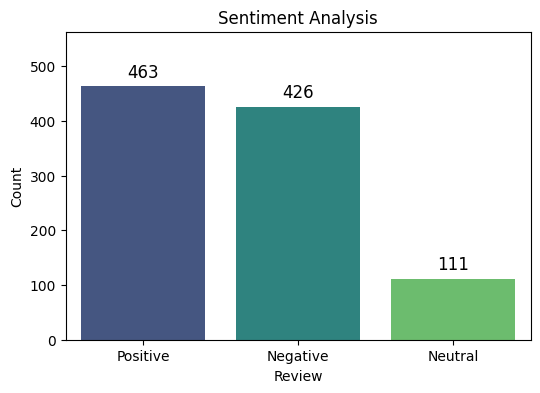

In [11]:
# Create the bar plot
plt.figure(figsize=(6, 4))
bars = sns.barplot(x=vader_counts.index, y=vader_counts.values, palette="viridis", legend=False)

# Add count annotations on the bars
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 10, f'{int(height)}', 
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.xlabel('Review')
plt.ylabel('Count')
plt.title('Sentiment Analysis')
plt.ylim(0, max(vader_counts.values) + 100)  # Adjust y-axis to fit count labels

# Show the plot
plt.show()

## Visualize Text (Keywords)

### Positive

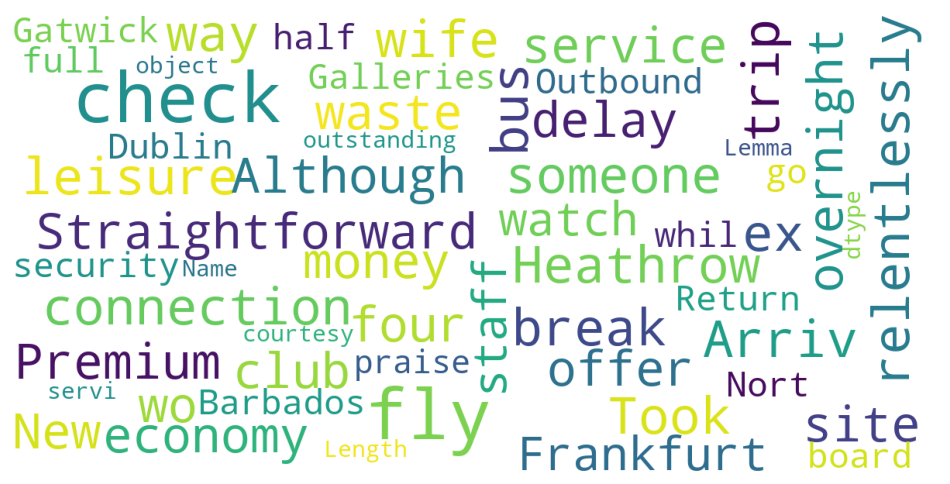

In [21]:
positive = df[df['Analysis']== 'Positive']

# Define common stopwords
custom_stopwords = ['BA','British','Airway','hour','back','one','will','flight','Airways','airline',\
                    'London','Nashville','Berlin']
stopwords = set(STOPWORDS) | set(custom_stopwords)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(positive.Lemma)

### Negative

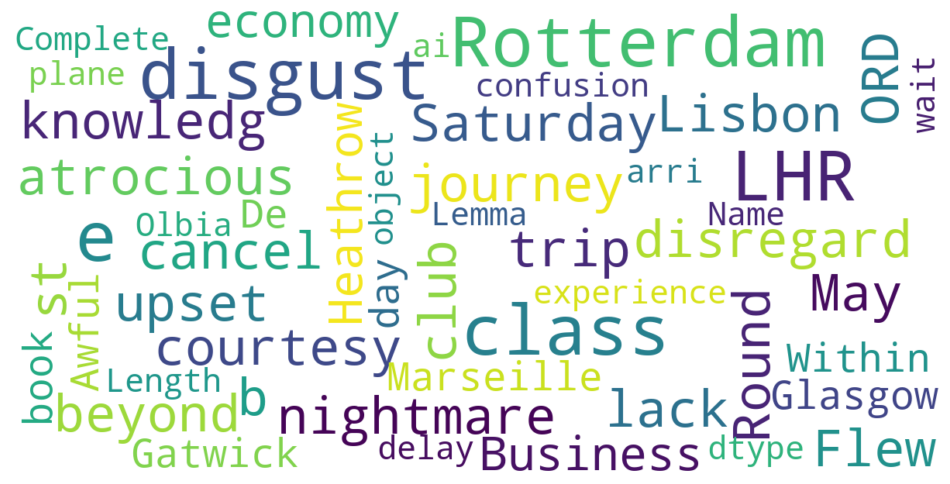

In [33]:
negative = df[df['Analysis']== 'Negative']

# Define common stopwords
custom_stopwords = ['BA','British','Airway','hour','back','one','will','flight','Airways','airline',\
                    'London','Nashville','Berlin', 'absolutely', 'europe','city']
stopwords = set(STOPWORDS) | set(custom_stopwords)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

show_wordcloud(negative.Lemma)